# COGS 108 - EDA Checkpoint

# Names

- Victoria Thai
- Hannah Yick
- Jane Dinh
- Natasha Supangkat
- Gabriel Ramiro

<a id='research_question'></a>
# Research Question

What trends can be found between a county’s designation of a superfund site and its socioeconomic/demographic trends? Does the demographic makeup of a county influence the amount of time between Superfund designation and the completion of the remediation process?

# Setup

In [1]:
#Imports 
import pandas as pd
import numpy as np

#Graphing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#Webscraping
import requests 
import bs4
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# Read in the data and store it within a data frame
#npl_df = npl_df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group011_sp21/main/All%20current%20Final%20NPL%20Sites%20(FOIA%204).csv?token=AI2VKGQIIMQPBWGAZGPKD5DASR4CO') 
gdrive_npl_id = '1oDIJ_v9s5i5THULln_C-N4o3Aiz0e7mu'
npl_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_npl_id}&export=download', encoding='ISO-8859-1')
gdrive_acs_id = '1kNWY1Kc4RhQ9ttK7dTYtj0fhHE3BXOGh'
acs_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_acs_id}&export=download', encoding='ISO-8859-1')

pd.options.display.max_rows = 5
pd.options.display.max_columns = 8

# Data Cleaning

Data cleaning from Checkpoint 1.

In [2]:
npl_df = npl_df.drop(["Region", "Site ID", "EPA ID", "Address", "Zip", "FF Ind", "Latitude", "Longitude"], axis=1)

In [3]:
acs_df = acs_df.drop([0], axis=0)
acs_df.reset_index(drop=True, inplace=True)

acs_df.dropna(axis = 0, how = 'all', inplace = True)
acs_df.dropna(axis = 1, how = 'all', inplace = True)

acs_df.drop(labels=['FIPS', 'Geographic Identifier', 'Summary Level', 'Geographic Component', 
                    'File identification', 'Logical Record Number', 'State (FIPS Code)', 
                    'County of current residence', 'Total Population.1', 'Population Density (Per Sq. Mile)', 
                    'Area (Land)', 'Total Population:', 'Total Population: White Alone', 
                    'Total Population: Black or African American Alone', 
                    'Total Population: American Indian and Alaska Native Alone', 'Total Population: Asian Alone', 
                    'Total Population: Native Hawaiian and Other Pacific Islander Alone', 
                    'Total Population: Some Other Race Alone', 'Total Population: Two or More Races'], axis=1, inplace = True)
acs_df.drop(index=acs_df[acs_df['State Postal Abbreviation'] == 'pr'].index, inplace=True)
acs_df.drop(list(acs_df.filter(regex = 'At or Above Poverty Level')), axis = 1, inplace = True)

acs_df = acs_df.iloc[:, np.r_[0:11, 12:23, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67]]

We'll need to adjust our dataset now that we have a better understanding of our data and how we want to work with it. Here, we'll work towards merging our two datasets by county. Let's start by standardizing the county variable of both datasets with a format of 'COUNTY, PC' where PC is the postal code (i.e. CA for California). This will handle instances where there are counties of the same name in different states.

First, let's take a look at our NPL dataset.

In [4]:
npl_df.sample(n=10)

,State,Site Name,City,County,NPL Status Date
524,FL,PENSACOLA NAVAL AIR STATION,PENSACOLA,ESCAMBIA,11/21/1989
625,SC,BARITE HILL/NEVADA GOLDFIELDS,MCCORMICK,MCCORMICK,4/9/2009
...,...,...,...,...,...
1280,OR,"UNITED CHROME PRODUCTS, INC.",CORVALLIS,BENTON,9/21/1984
403,PA,MILL CREEK DUMP,ERIE,ERIE,9/21/1984


Let's examine the dataset and check for missingness.

In [5]:
npl_df.isna().sum().sum()

20

In [6]:
npl_df.isna().any()

State              False
Site Name          False
City               False
County              True
NPL Status Date    False
dtype: bool

From this, we can see that all the missing data is in the County variable.

In [7]:
#subset to just rows with missing data
npl_df[npl_df.isnull().any(axis=1)]

,State,Site Name,City,County,NPL Status Date
266,NY,NEWTOWN CREEK,"BROOKLYN, QUEENS",NaN,9/29/2010
303,PR,FIBERS PUBLIC SUPPLY WELLS,JOBOS,NaN,9/21/1984
...,...,...,...,...,...
1263,ID,EASTERN MICHAUD FLATS CONTAMINATION,POCATELLO,NaN,8/30/1990
1264,ID,IDAHO NATIONAL ENGINEERING LABORATORY (USDOE),IDAHO FALLS,NaN,11/21/1989


We can see from the subset of missing data that these NPL sites are in valid cities in the United States, so there's no reason to drop them; however, they do not have data for the county. We will have to manually input these county values so that we can merge successfully before we go any further.

In [8]:
# manually input county names here
npl_df['County'][266] = 'KINGS-QUEENS'
npl_df['County'][303] = 'GUYAMA'
npl_df['County'][306] = 'UTUADO'
npl_df['County'][311] = 'TOA BAJA'
npl_df['County'][314] = 'VEGA ALTA'
npl_df['County'][495] = 'MORGAN-MADISON-LIMESTONE'
npl_df['County'][644] = 'AIKEN-ALLENDALE-BARNWELL'
npl_df['County'][661] = 'ANDERSON'
npl_df['County'][853] = 'HAMILTON'
npl_df['County'][881] = 'GREENE '
npl_df['County'][1127] = 'BUTTE-SILVER BOW'
npl_df['County'][1129] = 'MEADE'
npl_df['County'][1134] = 'DAVIS'
npl_df['County'][1256] = 'ALEUTIANS WEST CENSUS AREA'
npl_df['County'][1258] = 'ANCHORAGE'
npl_df['County'][1259] = 'ANCHORAGE'
npl_df['County'][1260] = 'FAIRBANKS NORTH STAR'
npl_df['County'][1261] = 'PRINCE OF WALES-HYDER CENSUS AREA'
npl_df['County'][1263] = 'BANNOCK'
npl_df['County'][1264] = 'BUTTE'

In [9]:
# clarify that all missing data has been addressed
npl_df.isna().sum().sum()

0

Now that all the county information is included, we'll convert the column names into lowercase, and continue this use of lowercase column names as we progress with both datasets as a standardization measure.

In [10]:
npl_df.columns = ['state', 'site name', 'city', 'county', 'npl status date']
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,MIDDLESEX,10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,WINDHAM,10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,FAIRFIELD,9/21/1984


Next we'll get our county variable information into the correct format by concatenating the state postal code.

In [11]:
npl_df['county'] = npl_df['county'].map(str) + ', ' + npl_df['state'].map(str)
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,"MIDDLESEX, CT",10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,"WINDHAM, CT",10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,"FAIRFIELD, CT",9/21/1984


In addition, we added a Duration column that will come into play as we plot our data. The values in this variable are the number of years since NPL status for the site was established (up to 2021).

In [12]:
npl_df['duration'] = npl_df['npl status date'].str[-4:]
npl_df = npl_df.astype({"duration": int})
npl_df['duration'] = 2021 - npl_df['duration']
npl_df

,state,site name,city,county,npl status date,duration
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989,32
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983,38
...,...,...,...,...,...,...
1325,WA,"WESTERN PROCESSING CO., INC.",KENT,"KING, WA",9/8/1983,38
1326,WA,WYCKOFF CO./EAGLE HARBOR,BAINBRIDGE ISLAND,"KITSAP, WA",7/22/1987,34


Now we can take a look at our ACS dataset.

In [13]:
acs_df.head()

,Area Name,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,Autauga County,"Autauga County, Alabama",al,55380,...,26.19,16.97,4.37,11.12
1,Baldwin County,"Baldwin County, Alabama",al,212830,...,26.28,10.79,18.41,8.4
2,Barbour County,"Barbour County, Alabama",al,25361,...,50.34,55.85,61.25,14.71
3,Bibb County,"Bibb County, Alabama",al,22493,...,NaN,0,0,16.34
4,Blount County,"Blount County, Alabama",al,57681,...,2.64,19.1,25.46,12.33


We'll need to standardize the formatting for the column describing the county of each observation to match that of our NPL datset, which is of the format 'COUNTY, PC' with PC being the postal code abbreviation. We can achieve this using the .upper(), .replace(), and .strip() methods.

In [14]:
acs_df.rename({'Area Name': 'county'}, axis=1, inplace=True)
acs_df['State Postal Abbreviation'] = acs_df['State Postal Abbreviation'].str.upper()
acs_df['county'] = acs_df['county'].str.upper()
acs_df['county'] = acs_df['county'].str.replace('COUNTY', '')
acs_df['county'] = acs_df['county'].str.strip()
acs_df['county'] = acs_df['county'].map(str) + ', ' + acs_df['State Postal Abbreviation'].map(str)
acs_df.head()

,county,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,"AUTAUGA, AL","Autauga County, Alabama",AL,55380,...,26.19,16.97,4.37,11.12
1,"BALDWIN, AL","Baldwin County, Alabama",AL,212830,...,26.28,10.79,18.41,8.4
2,"BARBOUR, AL","Barbour County, Alabama",AL,25361,...,50.34,55.85,61.25,14.71
3,"BIBB, AL","Bibb County, Alabama",AL,22493,...,NaN,0,0,16.34
4,"BLOUNT, AL","Blount County, Alabama",AL,57681,...,2.64,19.1,25.46,12.33


Now that we have a common column, we can merge our datasets. We'll use a left merge with our NPL dataset as our left-dataset, since we only need the demographic data for the county of the NPL sites.

In [15]:
county_df = pd.merge(npl_df, acs_df, on='county', how='left')
county_df = county_df.sort_values(by=['county'])
county_df.sample(n=5)

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
356,PA,BAGHURST DRIVE,HARLEYSVILLE,"MONTGOMERY, PA",...,18.29,9.38,16.35,4.37
1237,CA,"SPECTRA-PHYSICS, INC.",MOUNTAIN VIEW,"SANTA CLARA, CA",...,13.4,7.65,10.99,5.27
224,NY,CLAREMONT POLYCHEMICAL,OLD BETHPAGE,"NASSAU, NY",...,13.62,8.57,10.78,3.63
950,NM,MCGAFFEY AND MAIN GROUNDWATER PLUME,ROSWELL,"CHAVES, NM",...,15.14,12.42,24.24,11.04
384,PA,FRANKLIN SLAG PILE (MDC),PHILADELPHIA,"PHILADELPHIA, PA",...,41.47,24.56,37.47,13.35


# Data Analysis & Results (EDA)

### Median Household Income

Let's narrow down the scope of our dataset for this portion - we'll create a subset using just the relevant variables, including county, site name, and median household income. We'll also drop any rows in the subset with missing data for median household income, as this is essential to our current exploration.

In [16]:
mhi_df = county_df[['site name', 'county', 'Median Household Income (In 2019 Inflation Adjusted Dollars):']]
mhi_df.rename({'Median Household Income (In 2019 Inflation Adjusted Dollars):': 'median household income'}, axis=1, inplace=True)
mhi_df = mhi_df.dropna(subset=['median household income'])
mhi_df['median household income'] = mhi_df['median household income'].astype(int)
mhi_df

,site name,county,median household income
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",71202
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",71202
...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",92069
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",45243


Visualizing the distribution of median household income for all of the relevant counties might be difficult - we have thousands of observations. We'll create two more subsets and compare their distributions:
1. 10 counties with the most NPL sites
2. 10 counties with the least NPL sites

We can start by getting a list of counties in order of their frequency in the dataset; we'll use the .value_counts() and .index.tolist() methods.

In [17]:
mhi_df.value_counts(['county'])

county         
SANTA CLARA, CA    21
MONTGOMERY, PA     17
                   ..
HENRY, AL           1
YUMA, AZ            1
Length: 621, dtype: int64

In [18]:
counties = mhi_df['county'].value_counts().index.tolist()

Now let's create the subsets by slicing the list into two lists of 10 counties.

In [19]:
top_10 = counties[0:10]
bottom_10 = counties[506:516]

In [20]:
top_10

['SANTA CLARA, CA',
 'LOS ANGELES, CA',
 'MONTGOMERY, PA',
 'MIDDLESEX, NJ',
 'NASSAU, NY',
 'MIDDLESEX, MA',
 'HARRIS, TX',
 'HILLSBOROUGH, FL',
 'NEW CASTLE, DE',
 'BURLINGTON, NJ']

In [21]:
mhi_top_df = mhi_df[mhi_df['county'].isin(top_10)]
mhi_top_df.head()

,site name,county,median household income
153,LANG PROPERTY,"BURLINGTON, NJ",87416
152,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",87416
189,ROEBLING STEEL CO.,"BURLINGTON, NJ",87416
149,"KAUFFMAN & MINTEER, INC.","BURLINGTON, NJ",87416
163,MCGUIRE AIR FORCE BASE #1,"BURLINGTON, NJ",87416


In [22]:
bottom_10

['JEFFERSON, KY',
 'DOUGLAS, OR',
 'ALACHUA, FL',
 'OTTAWA, MI',
 'BOONE, AR',
 'CLEAR CREEK, CO',
 'BRAZORIA, TX',
 'HARRISON, WV',
 'ANDERSON, TN',
 'BUTTE, CA']

In [23]:
mhi_bottom_df = mhi_df[mhi_df['county'].isin(bottom_10)]
mhi_bottom_df.head()

,site name,county,median household income
503,CABOT/KOPPERS,"ALACHUA, FL",49689
661,OAK RIDGE RESERVATION (USDOE),"ANDERSON, TN",50392
918,"ARKWOOD, INC.","BOONE, AR",45374
979,GULFCO MARINE MAINTENANCE,"BRAZORIA, TX",81447
1196,"KOPPERS CO., INC. (OROVILLE PLANT)","BUTTE, CA",52537


Text(0, 0.5, 'County')

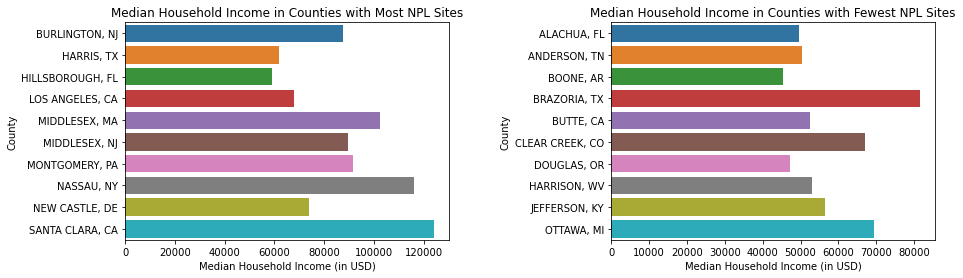

In [24]:
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=0.5, hspace=None)

ax1 = sns.barplot(x="median household income", y="county", data=mhi_top_df, ax=ax[0])

ax1.set_title('Median Household Income in Counties with Most NPL Sites')
ax1.set_xlabel('Median Household Income (in USD)')
ax1.set_ylabel('County')

ax2 = sns.barplot(x="median household income", y="county", data=mhi_bottom_df, ax=ax[1])

ax2.set_title('Median Household Income in Counties with Fewest NPL Sites')
ax2.set_xlabel('Median Household Income (in USD)')
ax2.set_ylabel('County')

The results are interesting - it seems as if the subset of counties with just 1 NPL site has higher median household income measures than the subset of counties with the most. This is revealing the limitation of the mhi_bottom_df subset in that there are many counties with just 1 NPL site, so the 10 in our sample might not be generalizable to the rest. As we move forward, we have several options: we can randomize the 10 counties in our sample (not just those at the bottom of the list), increase our sample size, or look at different ways of representing the data.

These bar plots also might hint that there could be a confounding variable here - if we look at the figure for counties with the most NPL sites, Santa Clara is a notable county in that it has a relatively high median household income of $120,000. Santa Clara is also in Silicon Valley, and upon further examination, most of these Superfund sites are located in past or current high-tech manufacturing sites (see https://qz.com/1017181/).

The Geospatial Analysis lecture from today (5/19) and continuing into Friday gave our group the idea to look into choropleth maps as an better method of data visualization, especially given the geographic nature of our data. For median household income in particular, it could be more insightful to plot one choropleth map of NPL sites by county amd another map of median household income by county, and compare the two maps. We will look into this once we learn more about geospatial analysis from lecture and other assignments!

### Duration of NPL Sites

In the same manner as how we analyzed the two subsets of the median household income, we will follow similar procedures to evaluate the significance of Superfund designation and coinciding factors. 

In [25]:
site_duration = county_df[['site name','county','duration','npl status date']]
site_duration.rename({'npl status date': 'year'}, axis=1, inplace=True)
site_duration['year'] = site_duration['year'].str[-4:]
site_duration = site_duration.astype({"year": int})
site_duration

,site name,county,duration,year
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",9,2012
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",37,1984
...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",27,1994
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",31,1990


In [26]:
site_duration_top_df = site_duration[site_duration['county'].isin(top_10)]
site_duration_bottom_df = site_duration[site_duration['county'].isin(bottom_10)]

Text(0, 0.5, 'County')

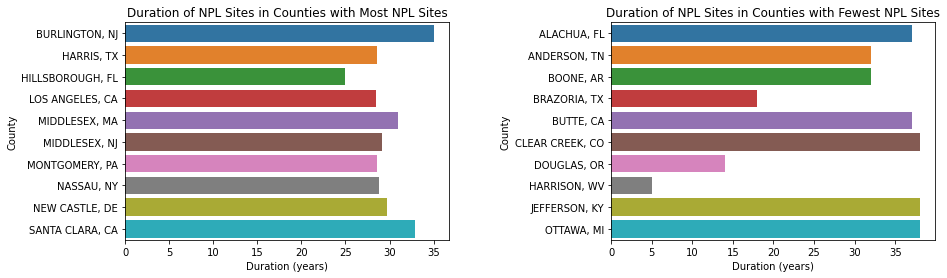

In [27]:
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=0.5, hspace=None)

ax1 = sns.barplot(x="duration", y="county", data=site_duration_top_df, ax=ax[0], ci=None)
ax1.set_title('Duration of NPL Sites in Counties with Most NPL Sites')
ax1.set_xlabel('Duration (years)')
ax1.set_ylabel('County')

ax2 = sns.barplot(x="duration", y="county", data=site_duration_bottom_df, ax=ax[1], ci=None)
ax2.set_title('Duration of NPL Sites in Counties with Fewest NPL Sites')
ax2.set_xlabel('Duration (years)')
ax2.set_ylabel('County')

In [28]:
pd.merge(site_duration_top_df.describe(), site_duration_bottom_df.describe(), 
         left_index=True, right_index=True, suffixes=('', '2'))

,duration,year,duration2,year2
count,144.000000,144.000000,10.00,10.0
mean,29.777778,1991.222222,28.90,1992.1
...,...,...,...,...
75%,37.000000,1996.000000,37.75,1999.5
max,38.000000,2018.000000,38.00,2016.0


As seen in the models above, the results show that on average, the designation of NPL sites in counties with the most NPL sites tends to be longer compared to NPL sites in counties with the fewest NPL sites. However, again, since the bottom 10 counties might not be generalizable to the rest, this may be giving us misrepresented results. 

The results further insinuate that regions with high NPL sites with long-duration lengths may be affecting the surrounding regions' median household income. The top 10 NPL Sites have progressing remediation processes continuing just over 25 years. As we advance our research, we can expectantly seek to find other factors that may be involved. 

### Population

Let's create a subset using just the relevant variables, including county, site name, and Total Population. We'll also drop any rows in the subset with missing data for Total Population.

In [29]:
pop_df = county_df[['site name', 'county', 'Total Population']]
pop_df = pop_df.dropna(subset=['Total Population'])
pop_df['Total Population'] = pop_df['Total Population'].astype(int)
pop_df

,site name,county,Total Population
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",504108
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",504108
...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",67982
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",209468


We'll create two more subsets and compare their distributions:
1. 10 counties with the most NPL sites
2. 10 counties with the least NPL sites

We can start by getting a list of counties in order of their frequency in the dataset; we'll use the .value_counts() and .index.tolist() methods. These dataframes will be different from the other top 10 and bottom 10 dataframes because it will be extracted from the population dataframe. 

In [30]:
pop_counties = pop_df['county'].value_counts().index.tolist()

In [31]:
pop_top_10 = pop_counties[0:10]
pop_top_df = pop_df[pop_df['county'].isin(pop_top_10)]
pop_top_df

,site name,county,Total Population
153,LANG PROPERTY,"BURLINGTON, NJ",445702
152,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",445702
...,...,...,...
1178,FAIRCHILD SEMICONDUCTOR CORP. (MOUNTAIN VIEW P...,"SANTA CLARA, CA",1927470
1241,TELEDYNE SEMICONDUCTOR,"SANTA CLARA, CA",1927470


In [32]:
pop_bottom_10 = pop_counties[615-10:]
pop_bottom_df = pop_df[pop_df['county'].isin(pop_bottom_10)]
pop_bottom_df

,site name,county,Total Population
288,SINCLAIR REFINERY,"ALLEGANY, NY",46688
1033,CHEROKEE COUNTY,"CHEROKEE, KS",20179
...,...,...,...
657,MALLORY CAPACITOR CO.,"WAYNE, TN",16693
95,OLD SPRINGFIELD LANDFILL,"WINDSOR, VT",55275


[(0.0, 10500000.0)]

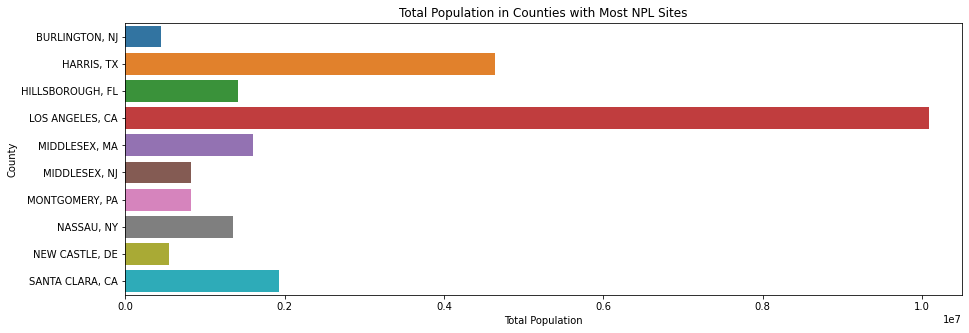

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
pop_top_plot = sns.barplot(x="Total Population", y="county", data=pop_top_df)


pop_top_plot.set_title('Total Population in Counties with Most NPL Sites')
pop_top_plot.set_xlabel('Total Population')
pop_top_plot.set_ylabel('County')
pop_top_plot.set(xlim=(0, 10500000))


[(0.0, 10500000.0)]

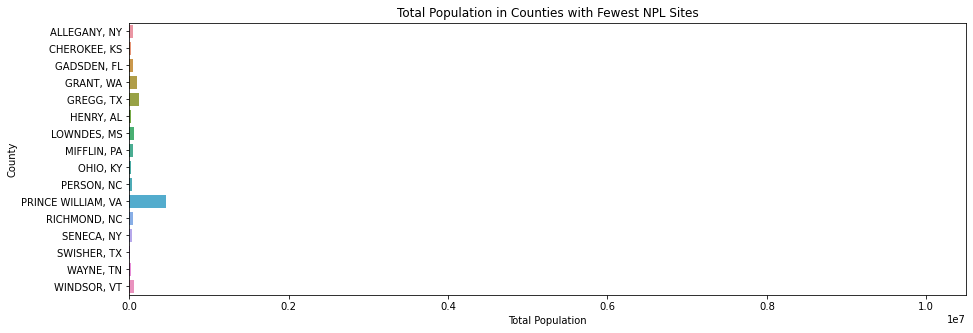

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
pop_bottom_plot = sns.barplot(x="Total Population", y="county", data=pop_bottom_df)

pop_bottom_plot.set_title('Total Population in Counties with Fewest NPL Sites')
pop_bottom_plot.set_xlabel('Total Population')
pop_bottom_plot.set_ylabel('County')
pop_bottom_plot.set(xlim=(0, 10500000))



From the plots above have the same axis limits in order to see the difference in scale for population. We can see that the counties with the most NPL sites have more people living in them than the counties with the fewest NPL sites. 

Now, we'll look into the population percentage by race. Let's create dataframes for this and drop the NaN values. 

In [35]:
popper_df = county_df[['site name', 'county', '% Total Population: White Alone', 
           '% Total Population: Black or African American Alone', 
           '% Total Population: American Indian and Alaska Native Alone',
           '% Total Population: Asian Alone', 
           '% Total Population: Native Hawaiian and Other Pacific Islander Alone', 
           '% Total Population: Some Other Race Alone', 
           '% Total Population: Two or More Races']]

popper_df = popper_df.dropna()

col = ['% Total Population: White Alone', 
           '% Total Population: Black or African American Alone', 
           '% Total Population: American Indian and Alaska Native Alone',
           '% Total Population: Asian Alone', 
           '% Total Population: Native Hawaiian and Other Pacific Islander Alone', 
           '% Total Population: Some Other Race Alone', 
           '% Total Population: Two or More Races']

popper_df[col] = popper_df[col].apply(pd.to_numeric)

popper_df


,site name,county,% Total Population: White Alone,% Total Population: Black or African American Alone,...,% Total Population: Asian Alone,% Total Population: Native Hawaiian and Other Pacific Islander Alone,% Total Population: Some Other Race Alone,% Total Population: Two or More Races
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",81.56,3.38,...,3.95,0.12,5.56,4.34
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",81.56,3.38,...,3.95,0.12,5.56,4.34
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",74.44,13.29,...,5.64,0.33,1.43,4.61
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",76.32,2.16,...,1.33,0.08,15.84,2.72


We will want to eventually have a subplot of White, Black, Asian, and Other Race. So let's add together American Indian and Alaska Native alone, Native Hawaiian and Other Pacific Islander Alone, Some Other Race Alone, and Two or More Races. Then we'll add this into a new column in our population percentage dataframe. 

In [36]:
other_race = popper_df['% Total Population: Asian Alone']+popper_df['% Total Population: American Indian and Alaska Native Alone'] + popper_df['% Total Population: Native Hawaiian and Other Pacific Islander Alone'] + popper_df['% Total Population: Some Other Race Alone'] + popper_df['% Total Population: Two or More Races']
popper_df["% Total Population: Native American + Other Races"] = other_race

popper_df

,site name,county,% Total Population: White Alone,% Total Population: Black or African American Alone,...,% Total Population: Native Hawaiian and Other Pacific Islander Alone,% Total Population: Some Other Race Alone,% Total Population: Two or More Races,% Total Population: Native American + Other Races
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",81.56,3.38,...,0.12,5.56,4.34,15.07
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",81.56,3.38,...,0.12,5.56,4.34,15.07
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",74.44,13.29,...,0.33,1.43,4.61,12.27
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",76.32,2.16,...,0.08,15.84,2.72,21.51


Now, we'll get the population percentages in counties with the most NPL sites and the least NPL sites. 

In [37]:
popper_counties = popper_df['county'].value_counts().index.tolist()

In [38]:
popper_top_10 = popper_counties[0:10]
popper_top_df = popper_df[popper_df['county'].isin(popper_top_10)]
popper_top_df

,site name,county,% Total Population: White Alone,% Total Population: Black or African American Alone,...,% Total Population: Native Hawaiian and Other Pacific Islander Alone,% Total Population: Some Other Race Alone,% Total Population: Two or More Races,% Total Population: Native American + Other Races
153,LANG PROPERTY,"BURLINGTON, NJ",72.02,16.89,...,0.06,1.98,3.85,11.10
152,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",72.02,16.89,...,0.06,1.98,3.85,11.10
...,...,...,...,...,...,...,...,...,...
1178,FAIRCHILD SEMICONDUCTOR CORP. (MOUNTAIN VIEW P...,"SANTA CLARA, CA",44.47,2.49,...,0.38,10.50,5.20,53.05
1241,TELEDYNE SEMICONDUCTOR,"SANTA CLARA, CA",44.47,2.49,...,0.38,10.50,5.20,53.05


In [39]:
popper_bottom_10 = popper_counties[615-10:]
popper_bottom_df = popper_df[popper_df['county'].isin(popper_bottom_10)]
popper_bottom_df

,site name,county,% Total Population: White Alone,% Total Population: Black or African American Alone,...,% Total Population: Native Hawaiian and Other Pacific Islander Alone,% Total Population: Some Other Race Alone,% Total Population: Two or More Races,% Total Population: Native American + Other Races
288,SINCLAIR REFINERY,"ALLEGANY, NY",95.45,1.50,...,0.03,0.46,1.15,3.04
1033,CHEROKEE COUNTY,"CHEROKEE, KS",90.11,0.59,...,0.37,0.34,6.32,9.29
...,...,...,...,...,...,...,...,...,...
657,MALLORY CAPACITOR CO.,"WAYNE, TN",91.40,6.85,...,0.00,0.31,0.50,1.75
95,OLD SPRINGFIELD LANDFILL,"WINDSOR, VT",95.64,0.73,...,0.07,0.63,1.89,3.62


[(0.0, 100.0)]

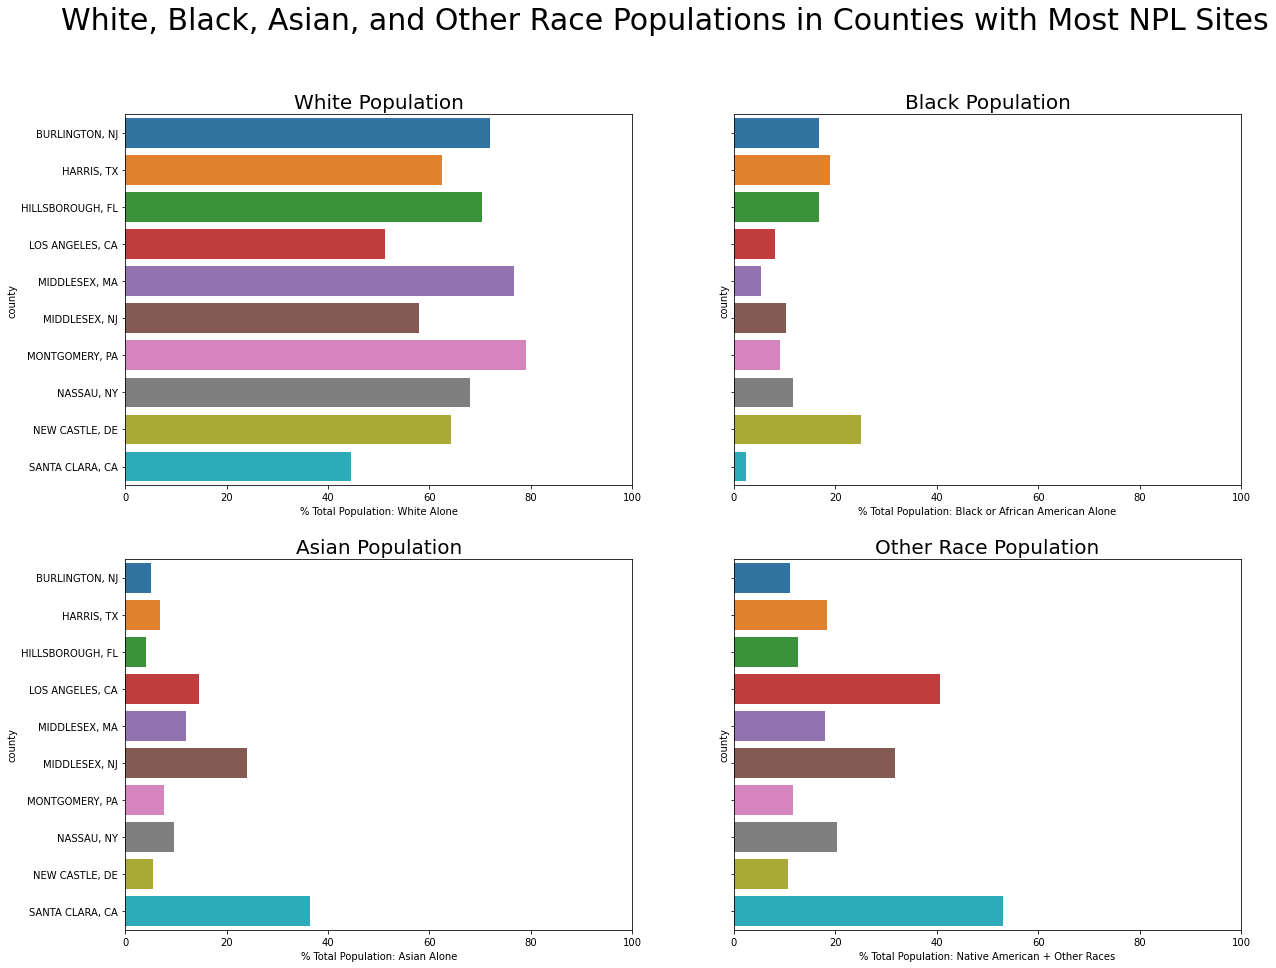

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)
fig.suptitle('White, Black, Asian, and Other Race Populations in Counties with Most NPL Sites', fontsize=30)


white = sns.barplot(ax=axes[0,0], x='% Total Population: White Alone', y='county',data=popper_top_df)
axes[0,0].set_title('White Population',fontsize=20)
white.set(xlim=(0, 100))

black = sns.barplot(ax=axes[0,1], x='% Total Population: Black or African American Alone', y='county', data=popper_top_df)
axes[0,1].set_title('Black Population',fontsize=20)
black.set(xlim=(0, 100))

asian = sns.barplot(ax=axes[1,0], x='% Total Population: Asian Alone', y='county', data=popper_top_df)
axes[1,0].set_title('Asian Population',fontsize=20)
asian.set(xlim=(0, 100))


other = sns.barplot(ax=axes[1,1], x='% Total Population: Native American + Other Races', y='county', data=popper_top_df)
axes[1,1].set_title('Other Race Population',fontsize=20)
other.set(xlim=(0,100))

[(0.0, 100.0)]

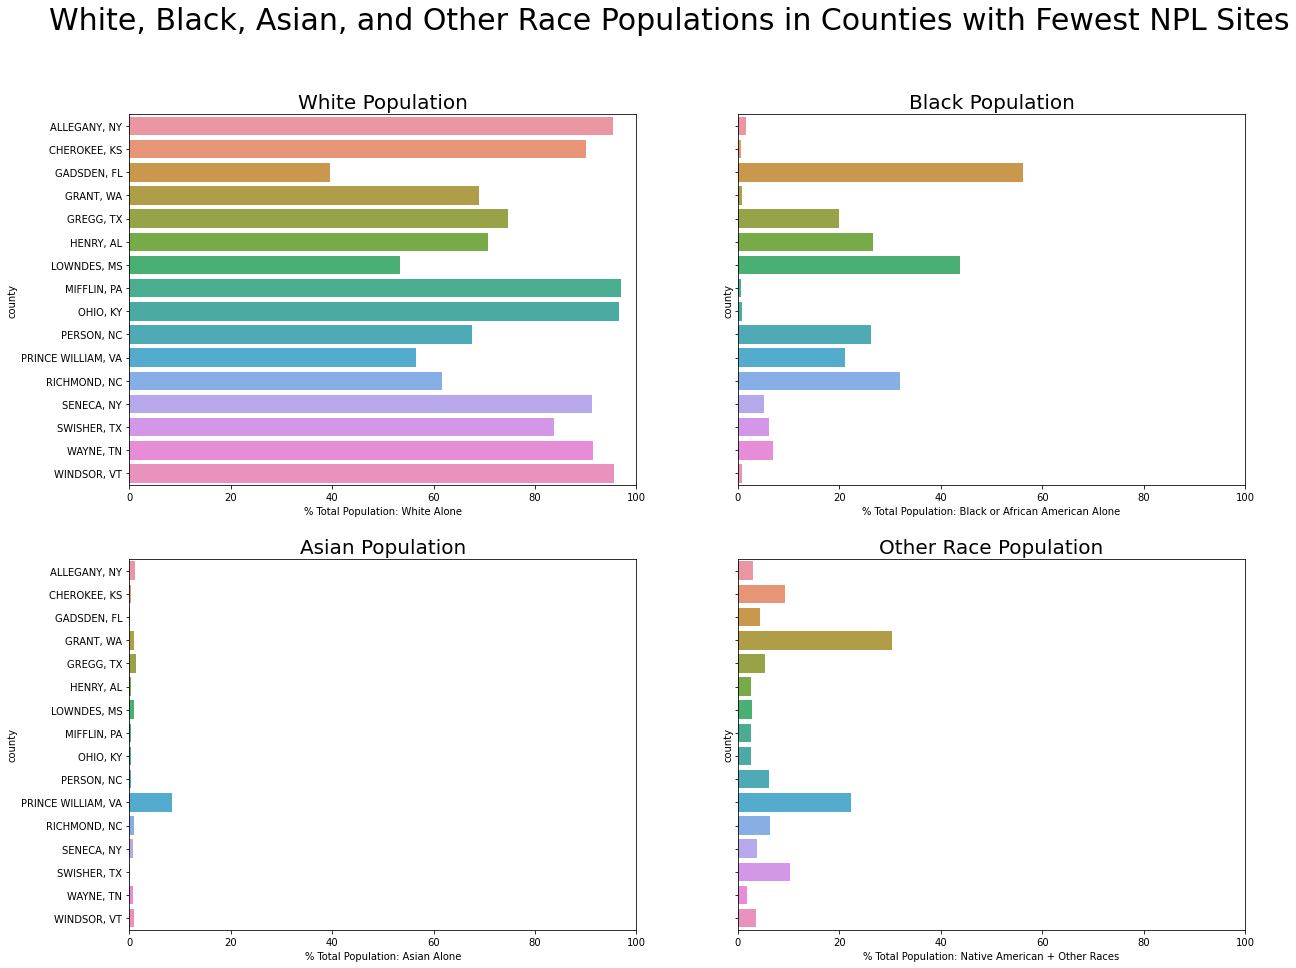

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)
fig.suptitle('White, Black, Asian, and Other Race Populations in Counties with Fewest NPL Sites', fontsize=30)

white = sns.barplot(ax=axes[0,0], x='% Total Population: White Alone', y='county',data=popper_bottom_df)
axes[0,0].set_title('White Population',fontsize=20)
white.set(xlim=(0, 100))

black = sns.barplot(ax=axes[0,1], x='% Total Population: Black or African American Alone', y='county', data=popper_bottom_df)
axes[0,1].set_title('Black Population',fontsize=20)
black.set(xlim=(0, 100))

asian = sns.barplot(ax=axes[1,0], x='% Total Population: Asian Alone', y='county', data=popper_bottom_df)
axes[1,0].set_title('Asian Population',fontsize=20)
asian.set(xlim=(0, 100))


other = sns.barplot(ax=axes[1,1], x='% Total Population: Native American + Other Races', y='county', data=popper_bottom_df)
axes[1,1].set_title('Other Race Population',fontsize=20)
other.set(xlim=(0,100))

From the graphs above, we can see that there is a large white population in both counties with the most NPL sites and counties with the least NPL sites. However, there is a larger Black, Asian, and other race population in the counties with the most NPL sites than in the counties with the least NPL sites. 

### Per Capita Income and Poverty Percentages by Age

Next, we want to look at each county's Per Capita Income and Poverty Percentages by Age Bracket through these variables:

`site name`, `county`, `duration`, `Per Capita Income (In 2019 Inflation Adjusted Dollars)`* , `% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty`, `% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty`, `% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty`

\*According to [census.gov](https://www.census.gov/quickfacts/fact/note/US/INC910219), Per Capita Income is determined using the mean: "Per capita income is the mean income computed for every man, woman, and child in a particular group including those living in group quarters. It is derived by dividing the aggregate income of a particular group by the total population in that group. This measure is rounded to the nearest whole dollar."

We'll assign this subset of `county_df` to a new dataframe `age_df` to make it easier to work with:

In [42]:
age_df = county_df[['site name',
                    'county', 'state', 
                    'Per Capita Income (In 2019 Inflation Adjusted Dollars)', 
                    '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty', 
                    '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty', 
                    '% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty']]
age_df['duration'] = site_duration['duration']
age_df.columns = ['site name', 'county', 'state', 'per_cap_income', 'pov_perc_under18', 'pov_perc_18to64', 'pov_perc_65up', 'duration']
#age_df

We'll then convert the numerical columns into floats to do calculations/manipulations on:

In [43]:
age_df[['per_cap_income', 'pov_perc_under18', 'pov_perc_18to64', 'pov_perc_65up', 'duration']] = age_df[['per_cap_income', 'pov_perc_under18', 'pov_perc_18to64', 'pov_perc_65up', 'duration']].astype(float)

age_df

,site name,county,state,per_cap_income,pov_perc_under18,pov_perc_18to64,pov_perc_65up,duration
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",LA,NaN,NaN,NaN,NaN,9.0
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",CO,30313.0,14.86,9.72,7.19,37.0
...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",VA,41201.0,6.24,4.34,5.24,27.0
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",AZ,21758.0,28.47,17.09,13.99,31.0


In [44]:
print("Total NaN values in age_df: ",
       age_df.isnull().sum().sum())
print("Total NaN values in age_df per column:\n",
      age_df.isnull().sum())

Total NaN values in age_df:  196
Total NaN values in age_df per column:
 site name         0
county            0
                 ..
pov_perc_65up    49
duration          0
Length: 8, dtype: int64


In [45]:
#pd.options.display.max_rows = 48
null_data = age_df[age_df.isnull().any(axis=1)]
null_data

,site name,county,state,per_cap_income,pov_perc_under18,pov_perc_18to64,pov_perc_65up,duration
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",LA,NaN,NaN,NaN,NaN,9.0
644,SAVANNAH RIVER SITE (USDOE),"AIKEN-ALLENDALE-BARNWELL, SC",SC,NaN,NaN,NaN,NaN,32.0
...,...,...,...,...,...,...,...,...
935,LOUISIANA ARMY AMMUNITION PLANT,"WEBSTER, LA",LA,NaN,NaN,NaN,NaN,32.0
929,"AMERICAN CREOSOTE WORKS, INC. (WINNFIELD PLANT)","WINN, LA",LA,NaN,NaN,NaN,NaN,29.0


It appears that a good portion of the NaN values exist due to NPL sites located in U.S. territories, for which we do not have ACS data for. We can drop those rows from the dataframe: 

In [46]:
age_df.drop(index=age_df[age_df['county'].str.contains('PR|GUAM')].index, inplace=True)
county_df.drop(index=county_df[county_df['county'].str.contains('PR|GUAM')].index, inplace=True)
null_data = age_df[age_df.isnull().any(axis=1)]
null_data

,site name,county,state,per_cap_income,pov_perc_under18,pov_perc_18to64,pov_perc_65up,duration
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",LA,NaN,NaN,NaN,NaN,9.0
644,SAVANNAH RIVER SITE (USDOE),"AIKEN-ALLENDALE-BARNWELL, SC",SC,NaN,NaN,NaN,NaN,32.0
...,...,...,...,...,...,...,...,...
935,LOUISIANA ARMY AMMUNITION PLANT,"WEBSTER, LA",LA,NaN,NaN,NaN,NaN,32.0
929,"AMERICAN CREOSOTE WORKS, INC. (WINNFIELD PLANT)","WINN, LA",LA,NaN,NaN,NaN,NaN,29.0


It seems the remaining 29 observations do not have corresponding data from the ACS dataset.

Let's take a look at the dataframe's descriptive data:

In [47]:
pd.options.display.max_rows = 10
age_df.describe().round(2)

,per_cap_income,pov_perc_under18,pov_perc_18to64,pov_perc_65up,duration
count,1266.00,1266.00,1266.00,1266.00,1295.00
mean,34407.78,17.14,11.92,8.39,28.22
std,8948.60,7.79,4.77,2.93,10.19
min,15931.00,0.00,3.32,1.36,1.00
25%,28129.00,10.65,8.31,6.45,22.00
50%,32426.00,16.95,11.48,7.98,32.00
75%,39337.00,22.15,14.54,9.67,37.00
max,68883.00,55.90,36.26,24.08,38.00


Looking at the information above, the data fall in line with what we expected to find re: aggregate census income data of the US population. But we can get a better picture by charting it:

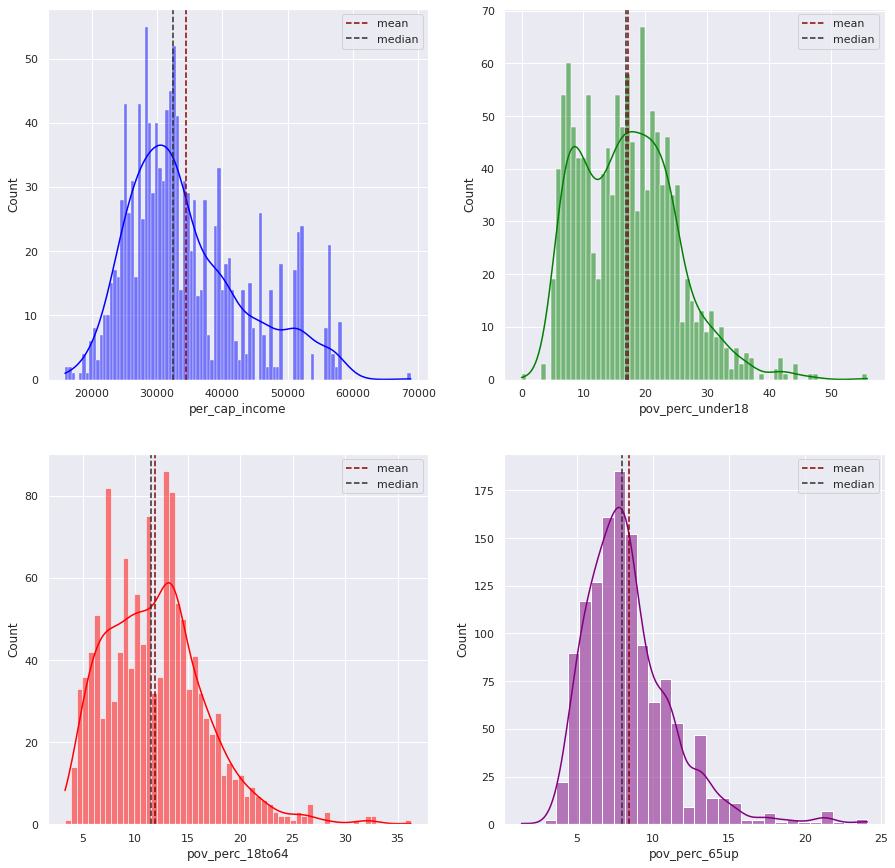

In [48]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.histplot(data=age_df, x="per_cap_income", kde=True, color="blue", ax=axs[0, 0], bins=100)
ax1.axvline(age_df['per_cap_income'].mean(), color='darkred', linestyle='--', label='mean');
ax1.axvline(age_df['per_cap_income'].median(), color = '#2e2e2e', linestyle='--', label='median')
ax1.legend()

ax2=sns.histplot(data=age_df, x="pov_perc_under18", kde=True, color="green", ax=axs[0, 1], bins=70)
ax2.axvline(age_df['pov_perc_under18'].mean(), color='darkred', linestyle='--', label='mean');
ax2.axvline(age_df['pov_perc_under18'].median(), color = '#2e2e2e', linestyle='--', label='median')
ax2.legend()

ax3=sns.histplot(data=age_df, x="pov_perc_18to64", kde=True, color="red", ax=axs[1, 0], bins=60)
ax3.axvline(age_df['pov_perc_18to64'].mean(), color='darkred', linestyle='--', label='mean');
ax3.axvline(age_df['pov_perc_18to64'].median(), color = '#2e2e2e', linestyle='--', label='median')
ax3.legend()

ax4=sns.histplot(data=age_df, x="pov_perc_65up", kde=True, color="purple", ax=axs[1, 1], bins=30)
ax4.axvline(age_df['pov_perc_65up'].mean(), color='darkred', linestyle='--', label='mean');
ax4.axvline(age_df['pov_perc_65up'].median(), color = '#2e2e2e', linestyle='--', label='median')
ax4.legend()

plt.show()

All four of these plot distributions appear right-skewed, driving the respective means slightly higher than the medians, especially for Per Capita Income. Let's take a look at the observations corresponding to the maximum and minimum `per_cap_income` values:

In [49]:
print('Observation w/ max per capita income: \n\n', age_df[age_df.per_cap_income == age_df.per_cap_income.max()], '\n\n')
print('Observation w/ min per capita income: \n\n', age_df[age_df.per_cap_income == age_df.per_cap_income.min()])

Observation w/ max per capita income: 

                          site name             county state  per_cap_income  \
1186  HUNTERS POINT NAVAL SHIPYARD  SAN FRANCISCO, CA    CA         68883.0   

      pov_perc_under18  pov_perc_18to64  pov_perc_65up  duration  
1186              9.96              9.7          13.61      32.0   


Observation w/ min per capita income: 

                       site name        county state  per_cap_income  \
952  PREWITT ABANDONED REFINERY  MCKINLEY, NM    NM         15931.0   
954        UNITED NUCLEAR CORP.  MCKINLEY, NM    NM         15931.0   

     pov_perc_under18  pov_perc_18to64  pov_perc_65up  duration  
952             43.95            32.55          24.08      31.0  
954             43.95            32.55          24.08      38.0  


Looking up demographic income information about San Francisco County, CA (the county with highest average per capita income) and McKinley County, NM (the lowest average per capita income), the large disparity checks out: San Francisco County has one of the nation's highest per capita income levels, while McKinley County, one of the lowest. 

While the range is large, they are not degrees apart from each other, so we will not be performing a log transformation on the data. 

Now let's figure out the frequency of NPL sites in each county. As each observation corresponds to a different NPL site accompanied by the county it resides in, we'll do this by adding up the number of times a county occurs in the dataframe:

In [50]:
age_df.value_counts(['county'])

county         
SANTA CLARA, CA    21
MONTGOMERY, PA     17
LOS ANGELES, CA    17
NASSAU, NY         14
MIDDLESEX, NJ      14
                   ..
HICKMAN, TN         1
HENRY, AL           1
HENRICO, VA         1
HENDERSON, NC       1
YUMA, AZ            1
Length: 640, dtype: int64

In [51]:
age_df.value_counts(['county']).describe()

count    640.000000
mean       2.023438
std        2.219084
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       21.000000
dtype: float64

Looking at the descriptive info above, the vast amount of observations have 1-2 NPL sites on the county level.

We'll add a column for `npl_count` that lists the NPL total for the observation's respective county:

In [52]:
pd.options.display.max_rows = 5
age_df['npl_count'] = age_df['county'].map(age_df['county'].value_counts())
age_df

,site name,county,state,per_cap_income,...,pov_perc_18to64,pov_perc_65up,duration,npl_count
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",LA,NaN,...,NaN,NaN,9.0,1
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",CO,30313.0,...,9.72,7.19,37.0,2
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",VA,41201.0,...,4.34,5.24,27.0,4
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",AZ,21758.0,...,17.09,13.99,31.0,1


Now that we've tabulated the `npl_count` of each respective `county`, we can chart per capita income and poverty rate information against it, starting with county level:

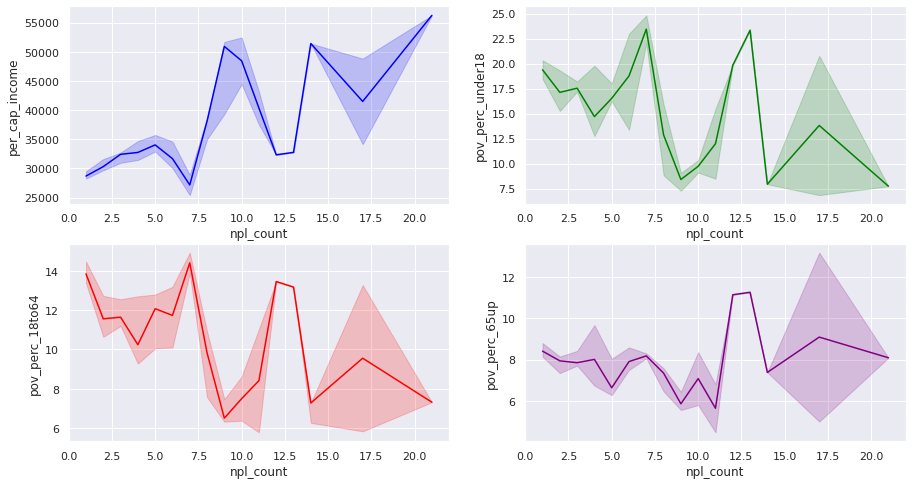

In [53]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
ax1=sns.lineplot(data=age_df, x="npl_count", y="per_cap_income", color="blue", estimator=np.median, ax=axs[0, 0])
ax2=sns.lineplot(data=age_df, x="npl_count", y="pov_perc_under18", color="green", estimator=np.median, ax=axs[0, 1])
ax3=sns.lineplot(data=age_df, x="npl_count", y="pov_perc_18to64", color="red", estimator=np.median, ax=axs[1, 0])
ax4=sns.lineplot(data=age_df, x="npl_count", y="pov_perc_65up", color="purple", estimator=np.median, ax=axs[1, 1])
plt.show()

The data seem fairly consistent between age brackets. It appears that the findings for these variables go in a different direction from hypothesis: counties with high NPL sites have higher incomes and lower poverty percentages. This finding checks out as the top two counties for NPL count (Santa Clara CA, Montgomery PA) have some of the higest income levels in the nation.

However, this finding may be constrained by the large staggering in data, the large range in npl_count values between ~13-21, and the fact that the majority of counties have 1-2 NPL sites.

Let's look at the comparison at a less granular state level:

In [54]:
age_df['npl_count_state'] = age_df['state'].map(age_df['state'].value_counts())

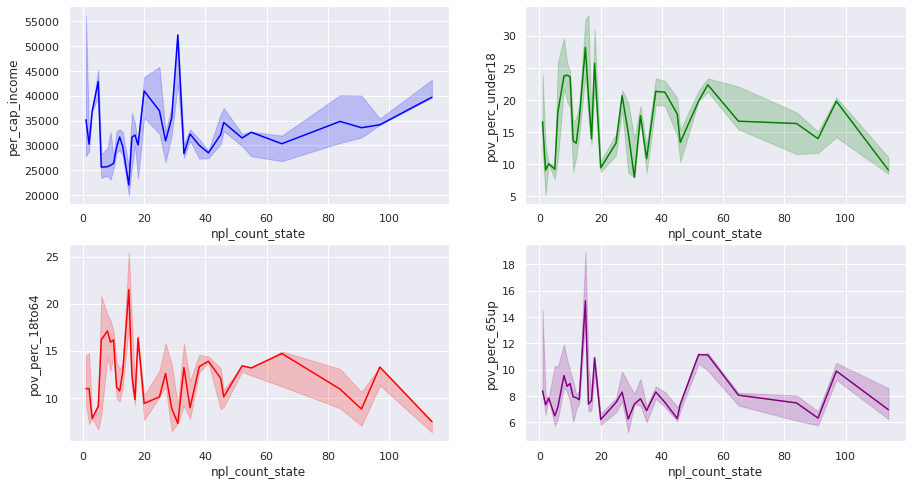

In [55]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
ax1=sns.lineplot(data=age_df, x="npl_count_state", y="per_cap_income", color="blue", estimator=np.median, ax=axs[0, 0])
ax2=sns.lineplot(data=age_df, x="npl_count_state", y="pov_perc_under18", color="green", estimator=np.median, ax=axs[0, 1])
ax3=sns.lineplot(data=age_df, x="npl_count_state", y="pov_perc_18to64", color="red",estimator=np.median, ax=axs[1, 0])
ax4=sns.lineplot(data=age_df, x="npl_count_state", y="pov_perc_65up", color="purple", estimator=np.median, ax=axs[1, 1])
plt.show()

The results of the state-level comparison shares some similar overall patterns as the county-level comparison, but even more staggered in the first half where most of the observations lie. As the NPL count increases, so does the range, which then tapers off toward the last quintile. 

To observe relationships between NPL sites and income and poverty, we can also take a look at how long it takes for an NPL site to be remedied, i.e. `duration`. We'll chart duration against income and poverty information: 

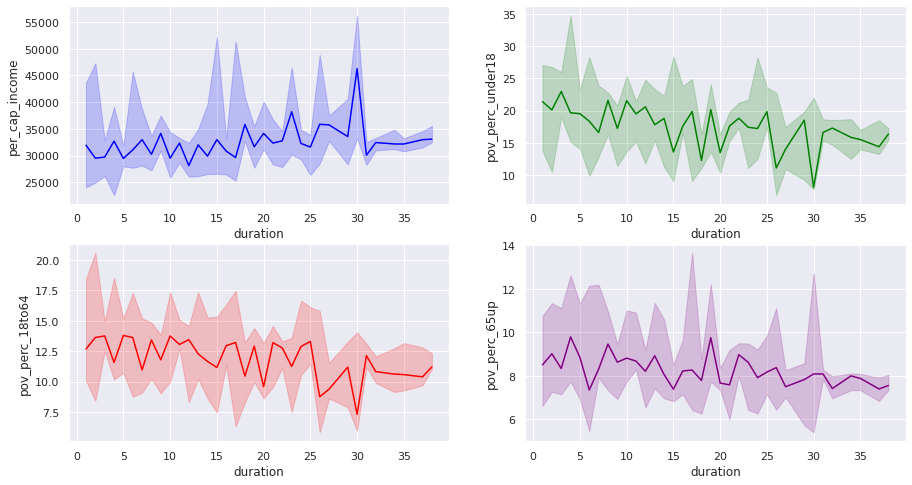

In [56]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
ax1=sns.lineplot(data=age_df, x="duration", y="per_cap_income", color="blue", estimator=np.median, ax=axs[0, 0])
ax2=sns.lineplot(data=age_df, x="duration", y="pov_perc_under18", color="green", estimator=np.median, ax=axs[0, 1])
ax3=sns.lineplot(data=age_df, x="duration", y="pov_perc_18to64", color="red", estimator=np.median, ax=axs[1, 0])
ax4=sns.lineplot(data=age_df, x="duration", y="pov_perc_65up", color="purple", estimator=np.median, ax=axs[1, 1])
plt.show()

From the relative lack of gradient from the above charts, there's not much of a case for the relationship between aforementioned income variables and the duration of an NPL site being under NPL status. 
However, we can also use a scatter matrix to see if there are any viable relationships within the dataframe:

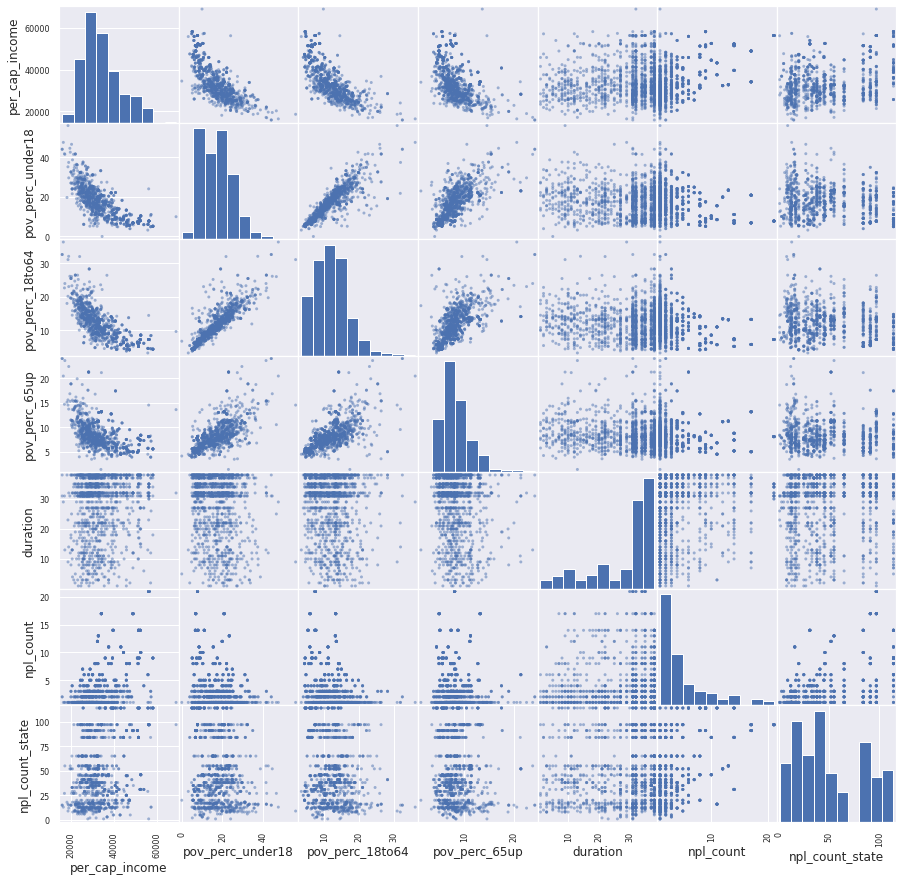

In [57]:
pd.plotting.scatter_matrix(age_df,
                           figsize  = [15, 15]);

The scatter matrix does not convey strong relationships between the npl variables (`npl_count`, `duration`) and the economic data. 

Looking at these economic (`per_cap_income`, `pov_perc_under18`, `pov_perc_18to64`, `pov_perc_65up`) and npl variables (`npl_count`, `duration`), it appears that these data do not necessarily support our initial hypothesis that there was a higher frequency and duration of NPL sites in areas with higher poverty, or that there may much of any relationship at all. Moreover, our findings for these variables may be constrained by the fact that the majority of observations have 1-2 NPL sites. 

### Income Below Poverty Level

For this section, we'll grab all the columns for site name, county, duration,| total population and all columns where "Income Below Poverty Level" is included (columns 30-38). We'll also rename the columns and delete rows that have missing data in the income below poverty level column.

In [97]:
below_pov_df = county_df[['site name',
                          'county',
                          'Total Population',
                          'duration',
                          '% White Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
                          '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
                          '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level',
                          '% Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
                          '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income Below Poverty Level',
                          '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
                          '% Two or More Races Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
                          '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
                          '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level']]

below_pov_df.columns = ['site name',
                       'county',
                       'total population',
                        'duration',
                       'perc_white_income_below_pov',
                       'perc_black_income_below_pov',
                       'perc_indigenous_income_below_pov',
                       'perc_asian_income_below_pov',
                       'perc_islander_income_below_pov',
                       'perc_other_income_below_pov',
                       'perc_two_income_below_pov',
                       'perc_hispanic_income_below_pov',
                       'perc_whitenonhisp_income_below_pov']
below_pov_df

,site name,county,total population,duration,...,perc_other_income_below_pov,perc_two_income_below_pov,perc_hispanic_income_below_pov,perc_whitenonhisp_income_below_pov
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",NaN,9,...,NaN,NaN,NaN,NaN
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",504108,37,...,13.1,13.15,15.15,6.69
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",67982,27,...,15.42,2.32,10.43,4.6
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",209468,31,...,21.49,21.6,23.45,11.28


Similar to the sections above, since we have thousands of rows of data which would be difficult to visualize, we'll compare two subsets made from this dataframe with the poverty levels of each race.
1. Counties with the most NPL sites
2. Counties with the least NPL sites

First, we're going to clean up our data a little more by combining some of the columns together, specifically the columns of two or more races, other, and white non-Hispanic.

In [98]:
print(below_pov_df.columns)

Index(['site name', 'county', 'total population', 'duration',
       'perc_white_income_below_pov', 'perc_black_income_below_pov',
       'perc_indigenous_income_below_pov', 'perc_asian_income_below_pov',
       'perc_islander_income_below_pov', 'perc_other_income_below_pov',
       'perc_two_income_below_pov', 'perc_hispanic_income_below_pov',
       'perc_whitenonhisp_income_below_pov'],
      dtype='object')


To add columns together, we'll have to convert the percentages in the columns into floats. Right now, they're object types.

In [99]:
below_pov_df.dtypes

site name                             object
county                                object
                                       ...  
perc_hispanic_income_below_pov        object
perc_whitenonhisp_income_below_pov    object
Length: 13, dtype: object

In [100]:
below_pov_df['perc_white_income_below_pov'] = below_pov_df['perc_white_income_below_pov'].astype(float)
below_pov_df['perc_black_income_below_pov'] = below_pov_df['perc_black_income_below_pov'].astype(float)
below_pov_df['perc_indigenous_income_below_pov'] = below_pov_df['perc_indigenous_income_below_pov'].astype(float)
below_pov_df['perc_asian_income_below_pov'] = below_pov_df['perc_asian_income_below_pov'].astype(float)
below_pov_df['perc_islander_income_below_pov'] = below_pov_df['perc_islander_income_below_pov'].astype(float)
below_pov_df['perc_other_income_below_pov'] = below_pov_df['perc_other_income_below_pov'].astype(float)
below_pov_df['perc_two_income_below_pov'] = below_pov_df['perc_two_income_below_pov'].astype(float)
below_pov_df['perc_hispanic_income_below_pov'] = below_pov_df['perc_hispanic_income_below_pov'].astype(float)
below_pov_df['perc_whitenonhisp_income_below_pov'] = below_pov_df['perc_whitenonhisp_income_below_pov'].astype(float)

below_pov_df.dtypes

site name                              object
county                                 object
                                       ...   
perc_hispanic_income_below_pov        float64
perc_whitenonhisp_income_below_pov    float64
Length: 13, dtype: object

We'll add the three columns mentioned above together and add it into our subset.

In [101]:
other_below = below_pov_df['perc_other_income_below_pov'] + below_pov_df['perc_two_income_below_pov'] + below_pov_df['perc_whitenonhisp_income_below_pov']
below_pov_df['perc_other_races_income_below_pov'] = other_below

below_pov_df

,site name,county,total population,duration,...,perc_two_income_below_pov,perc_hispanic_income_below_pov,perc_whitenonhisp_income_below_pov,perc_other_races_income_below_pov
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",NaN,9,...,NaN,NaN,NaN,NaN
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",504108,37,...,13.15,15.15,6.69,32.94
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",67982,27,...,2.32,10.43,4.60,22.34
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",209468,31,...,21.60,23.45,11.28,54.37


And we'll drop the ones we combined from our subset.

In [102]:
below_pov_df = below_pov_df.drop(['perc_other_income_below_pov', 'perc_two_income_below_pov', 'perc_whitenonhisp_income_below_pov'], axis=1)
below_pov_df

,site name,county,total population,duration,...,perc_asian_income_below_pov,perc_islander_income_below_pov,perc_hispanic_income_below_pov,perc_other_races_income_below_pov
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",NaN,9,...,NaN,NaN,NaN,NaN
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",504108,37,...,12.80,17.98,15.15,32.94
...,...,...,...,...,...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",67982,27,...,2.06,0.00,10.43,22.34
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",209468,31,...,6.52,24.37,23.45,54.37


We'll go ahead and check the rows for any missing values in the income below poverty level columns. We will delete rows that have missing values as those values are essential.

In [103]:
povnan = below_pov_df[below_pov_df.isnull().any(axis=1)]
povnan

,site name,county,total population,duration,...,perc_asian_income_below_pov,perc_islander_income_below_pov,perc_hispanic_income_below_pov,perc_other_races_income_below_pov
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",NaN,9,...,NaN,NaN,NaN,NaN
1079,GARVEY ELEVATOR,"ADAMS, NE",31587,16,...,18.91,NaN,20.73,57.84
...,...,...,...,...,...,...,...,...,...
1088,PCE SOUTHEAST CONTAMINATION,"YORK, NE",13745,7,...,0.00,NaN,40.81,108.93
1089,PCE/TCE NORTHEAST CONTAMINATION,"YORK, NE",13745,7,...,0.00,NaN,40.81,108.93


In [104]:
below_pov_df.isna().sum().sum()

374

There are a total of 374 missing values spread out in 153 rows of the dataset. We'll delete these rows, and reset the index.

In [105]:
below_pov_df = below_pov_df.dropna()
below_pov_df.reset_index(drop=True, inplace=True)
below_pov_df

,site name,county,total population,duration,...,perc_asian_income_below_pov,perc_islander_income_below_pov,perc_hispanic_income_below_pov,perc_other_races_income_below_pov
0,BRODERICK WOOD PRODUCTS,"ADAMS, CO",504108,37,...,12.80,17.98,15.15,32.94
1,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",504108,34,...,12.80,17.98,15.15,32.94
...,...,...,...,...,...,...,...,...,...
1140,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",67982,27,...,2.06,0.00,10.43,22.34
1141,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",209468,31,...,6.52,24.37,23.45,54.37


Let's check again to make sure we have no missing data.

In [106]:
below_pov_df.isna().sum().sum()

0

To find the top 10 and bottom 10 NPL sites in our subset, we'll use value_counts() and index.tolist() to sort.

In [107]:
below_pov_df.value_counts(['county'])

county         
SANTA CLARA, CA    21
MONTGOMERY, PA     17
                   ..
MCCRACKEN, KY       1
YUMA, AZ            1
Length: 515, dtype: int64

In [108]:
below_df = below_pov_df['county'].value_counts().index.tolist()

We'll slice for the first 10 and last 10 rows.

In [109]:
below_top_10 = below_df[0:10]
below_bottom_10 = below_df[515-10:]

In [110]:
below_top_10

['SANTA CLARA, CA',
 'MONTGOMERY, PA',
 'LOS ANGELES, CA',
 'MIDDLESEX, MA',
 'NASSAU, NY',
 'MIDDLESEX, NJ',
 'HARRIS, TX',
 'HILLSBOROUGH, FL',
 'NEW CASTLE, DE',
 'BURLINGTON, NJ']

In [111]:
below_bottom_10

['HARTFORD, CT',
 'BALTIMORE, MD',
 'AIKEN, SC',
 'YAKIMA, WA',
 "ST. MARY'S, MD",
 'CULPEPER, VA',
 'NORFOLK CITY, VA',
 'YADKIN, NC',
 'CAPE GIRARDEAU, MO',
 'ALLEGANY, NY']

Below is the subset of the top 10 counties with the most NPL sites.

In [112]:
below_pov_top_df = below_pov_df[below_pov_df['county'].isin(below_top_10)]
below_pov_top_df

,site name,county,total population,duration,...,perc_asian_income_below_pov,perc_islander_income_below_pov,perc_hispanic_income_below_pov,perc_other_races_income_below_pov
135,LANG PROPERTY,"BURLINGTON, NJ",445702,38,...,6.36,23.1,10.28,29.37
136,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",445702,37,...,6.36,23.1,10.28,29.37
...,...,...,...,...,...,...,...,...,...
964,FAIRCHILD SEMICONDUCTOR CORP. (MOUNTAIN VIEW P...,"SANTA CLARA, CA",1927470,30,...,6.76,8.3,10.99,26.32
965,TELEDYNE SEMICONDUCTOR,"SANTA CLARA, CA",1927470,34,...,6.76,8.3,10.99,26.32


And below is the subset of the top 10 counties with the least NPL sites.

In [113]:
below_pov_bottom_df = below_pov_df[below_pov_df['county'].isin(below_bottom_10)]
below_pov_bottom_df

,site name,county,total population,duration,...,perc_asian_income_below_pov,perc_islander_income_below_pov,perc_hispanic_income_below_pov,perc_other_races_income_below_pov
3,CLEARWATER FINISHING,"AIKEN, SC",168301,1,...,10.61,0.00,23.86,61.59
13,SINCLAIR REFINERY,"ALLEGANY, NY",46688,38,...,20.65,0.00,44.39,42.81
...,...,...,...,...,...,...,...,...,...
1124,HOLCOMB CREOSOTE CO,"YADKIN, NC",37602,9,...,0.00,0.00,27.57,67.81
1125,FMC CORP. (YAKIMA),"YAKIMA, WA",249697,38,...,17.79,12.59,21.94,48.66


With this data, we can start forming our plots. We'll keep the x-axis the same across our plots to compare the graphs together equally.

Text(0.5, 1.0, 'Other Race Percentage')

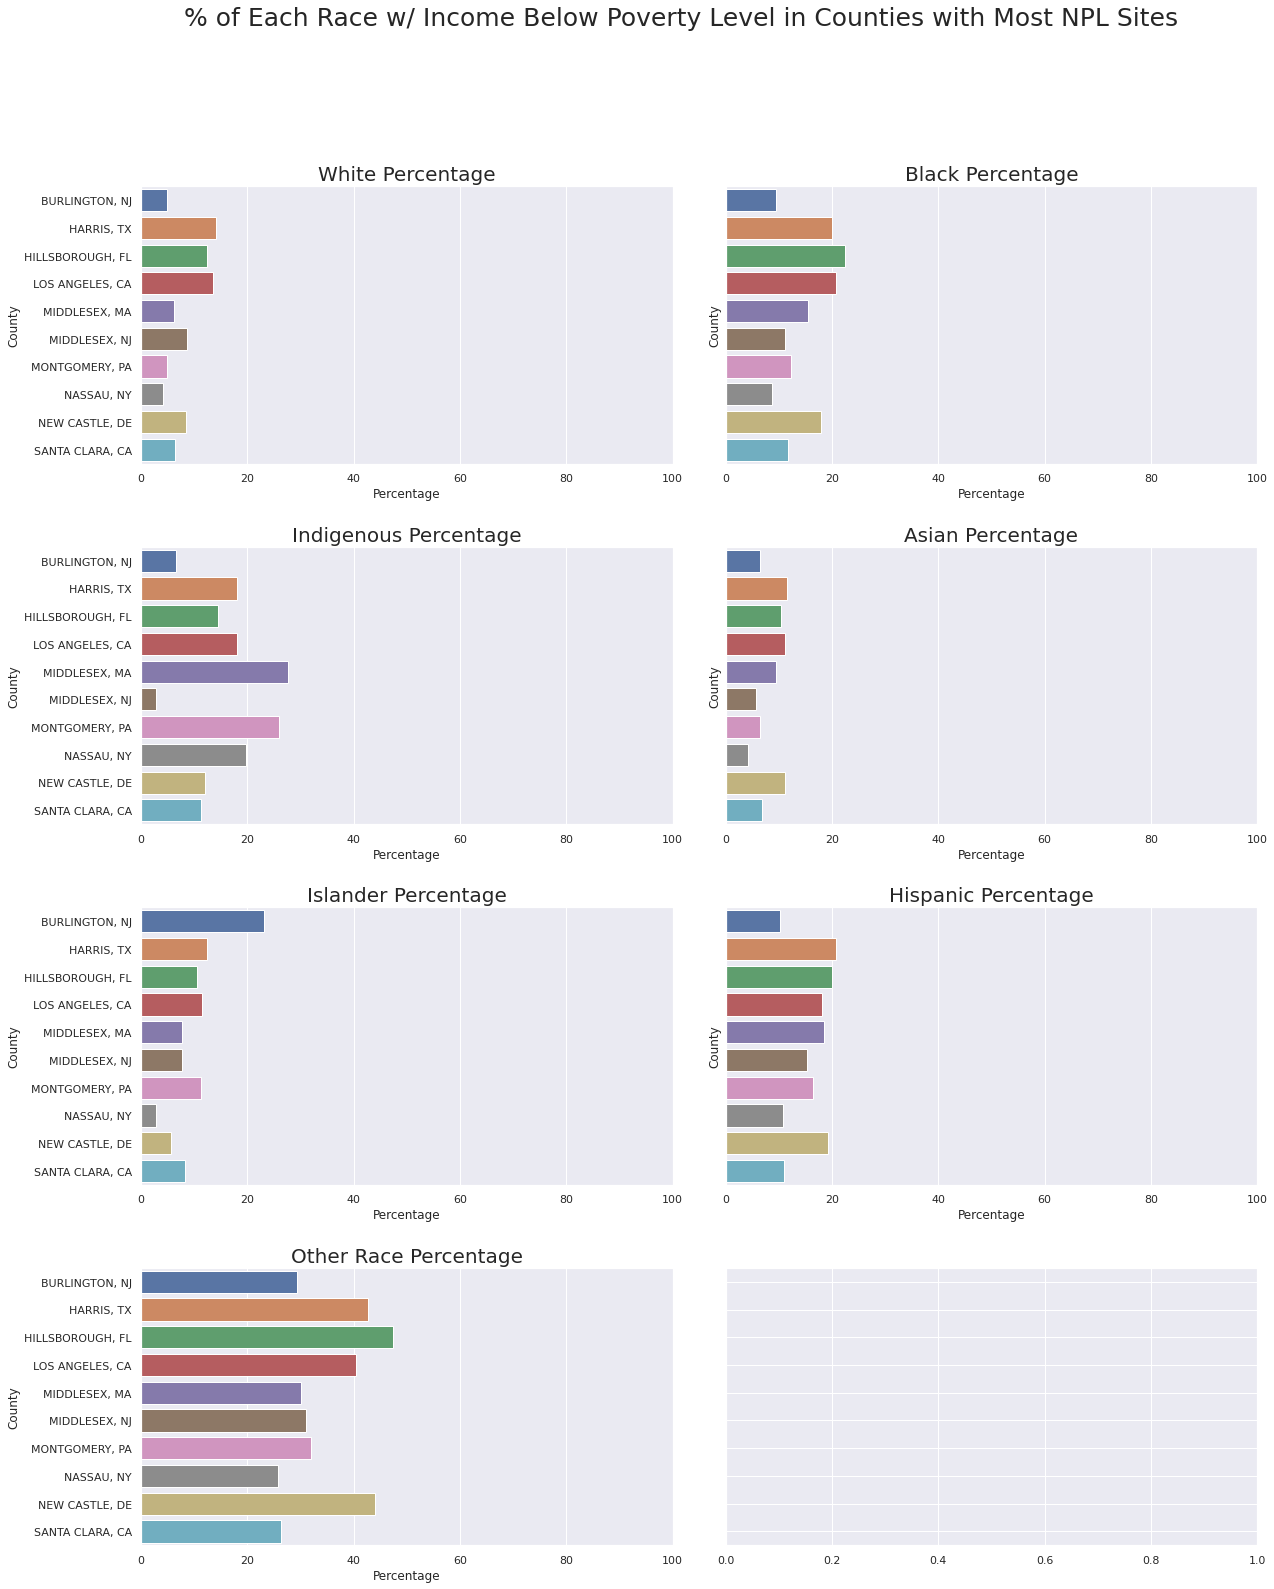

In [114]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(4, 2, figsize=(20, 25), sharey=True)
fig.suptitle('% of Each Race w/ Income Below Poverty Level in Counties with Most NPL Sites', fontsize=25)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

ax_white = sns.barplot(ax=ax[0,0], x='perc_white_income_below_pov', y='county', data=below_pov_top_df)
ax_white.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[0,0].set_title('White Percentage',fontsize=20)

ax_black = sns.barplot(ax=ax[0,1], x='perc_black_income_below_pov', y='county', data=below_pov_top_df)
ax_black.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[0,1].set_title('Black Percentage',fontsize=20)

ax_indigenous = sns.barplot(ax=ax[1,0], x='perc_indigenous_income_below_pov', y='county', data=below_pov_top_df)
ax_indigenous.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[1,0].set_title('Indigenous Percentage',fontsize=20)

ax_asian = sns.barplot(ax=ax[1,1], x='perc_asian_income_below_pov', y='county', data=below_pov_top_df)
ax_asian.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[1,1].set_title('Asian Percentage',fontsize=20)

ax_islander = sns.barplot(ax=ax[2,0], x='perc_islander_income_below_pov', y='county', data=below_pov_top_df)
ax_islander.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[2,0].set_title('Islander Percentage',fontsize=20)

ax_hispanic = sns.barplot(ax=ax[2,1], x='perc_hispanic_income_below_pov', y='county', data=below_pov_top_df)
ax_hispanic.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[2,1].set_title('Hispanic Percentage',fontsize=20)

ax_other = sns.barplot(ax=ax[3,0], x='perc_other_races_income_below_pov', y='county', data=below_pov_top_df)
ax_other.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[3,0].set_title('Other Race Percentage',fontsize=20)

Text(0.5, 1.0, 'Other Race Percentage')

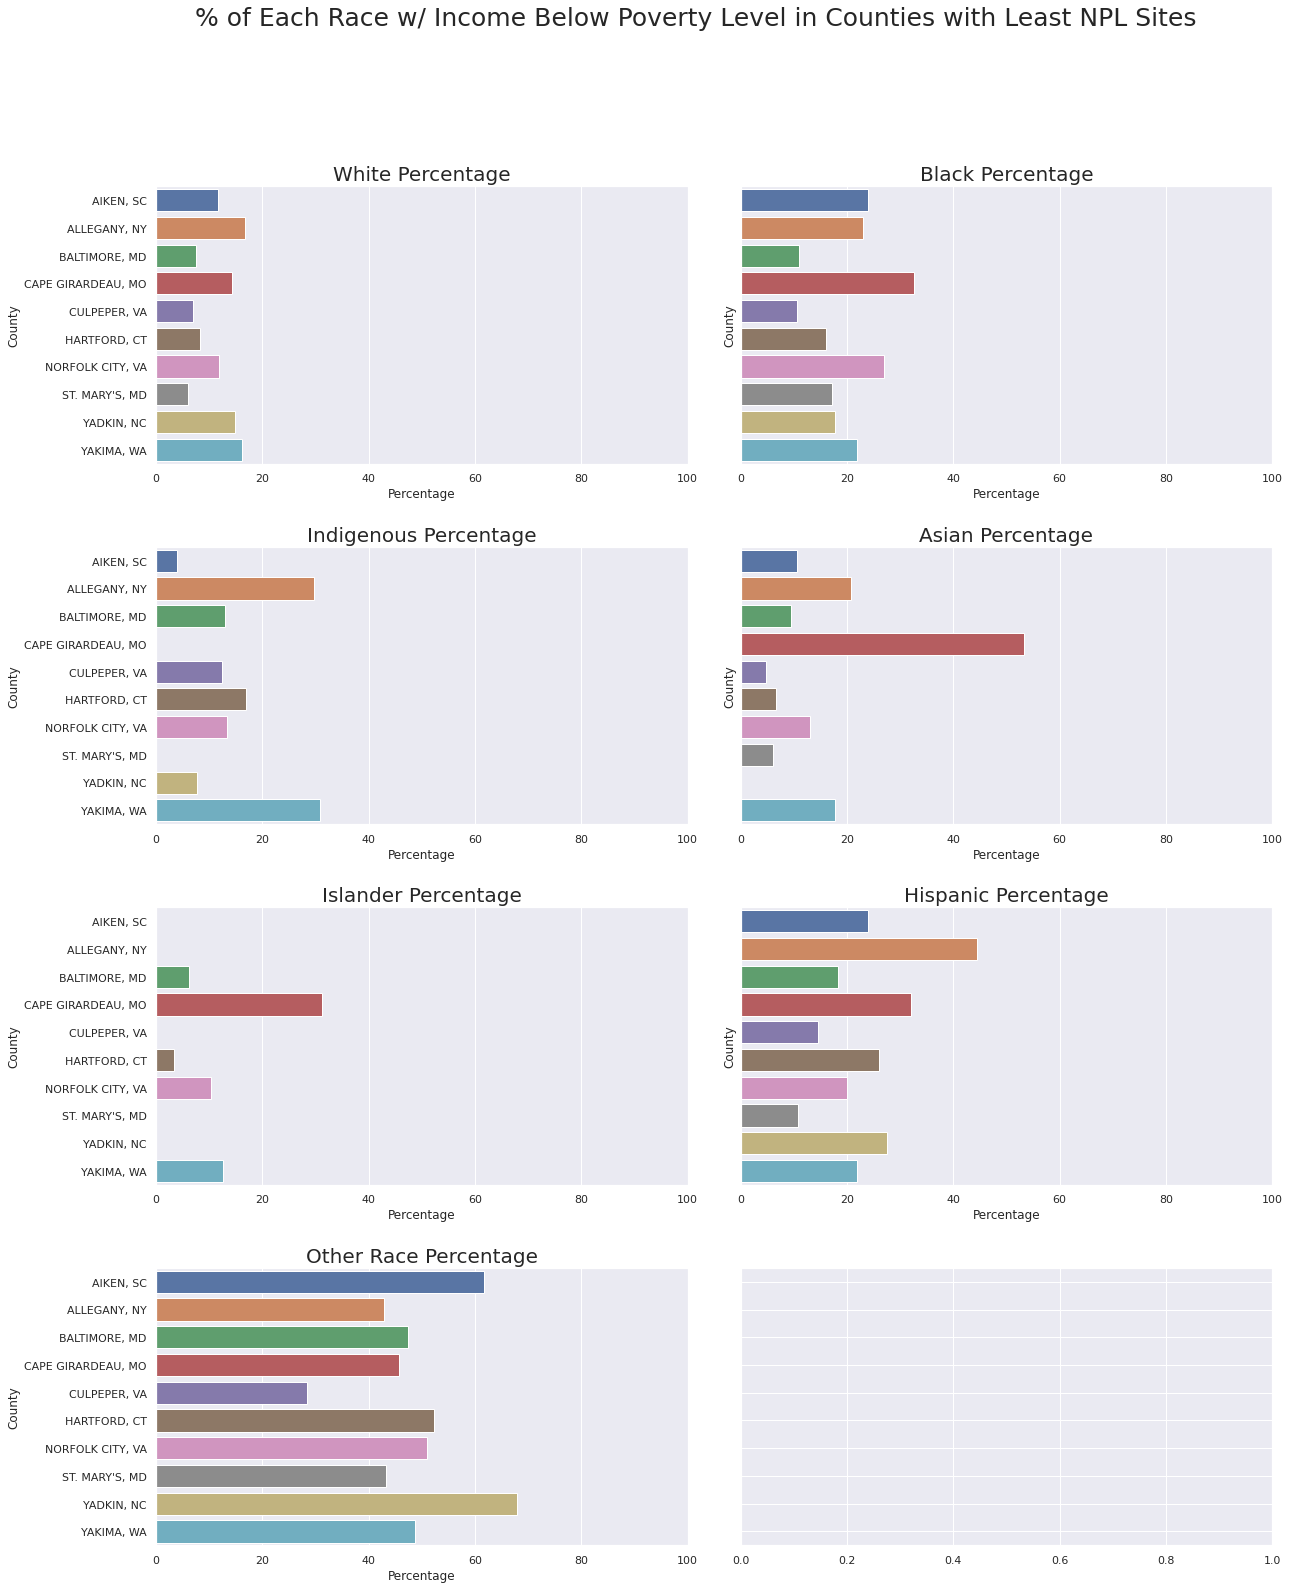

In [115]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(4, 2, figsize=(20, 25), sharey=True)
fig.suptitle('% of Each Race w/ Income Below Poverty Level in Counties with Least NPL Sites', fontsize=25)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

ax_white = sns.barplot(ax=ax[0,0], x='perc_white_income_below_pov', y='county', data=below_pov_bottom_df)
ax_white.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[0,0].set_title('White Percentage',fontsize=20)

ax_black = sns.barplot(ax=ax[0,1], x='perc_black_income_below_pov', y='county', data=below_pov_bottom_df)
ax_black.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[0,1].set_title('Black Percentage',fontsize=20)

ax_indigenous = sns.barplot(ax=ax[1,0], x='perc_indigenous_income_below_pov', y='county', data=below_pov_bottom_df)
ax_indigenous.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[1,0].set_title('Indigenous Percentage',fontsize=20)

ax_asian = sns.barplot(ax=ax[1,1], x='perc_asian_income_below_pov', y='county', data=below_pov_bottom_df)
ax_asian.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[1,1].set_title('Asian Percentage',fontsize=20)

ax_islander = sns.barplot(ax=ax[2,0], x='perc_islander_income_below_pov', y='county', data=below_pov_bottom_df)
ax_islander.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[2,0].set_title('Islander Percentage',fontsize=20)

ax_hispanic = sns.barplot(ax=ax[2,1], x='perc_hispanic_income_below_pov', y='county', data=below_pov_bottom_df)
ax_hispanic.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[2,1].set_title('Hispanic Percentage',fontsize=20)

ax_other = sns.barplot(ax=ax[3,0], x='perc_other_races_income_below_pov', y='county', data=below_pov_bottom_df)
ax_other.set(xlim=(0, 100), xlabel='Percentage', ylabel='County')
ax[3,0].set_title('Other Race Percentage',fontsize=20)


From the graphs above, we can see that there are the least percentage of the White population who are living below poverty levels for both counties with the most NPL site and with the least NPL sites. With the other races, however, there seem to be a larger percentage of each race's population that live below the poverty level in counties that have the least NPL sites compared to the counties with the most NPL sites. 

We have to consider that there might be limits to our bottom data as there are many counties that have only 1 NPL site. For the Other Races plot, since we added 3 columns together, the percentage of poverty is much higher compared to the other races as well. 